In [125]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import os
import statsmodels.api as sm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Задание 1
Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [418]:
df = pd.read_csv('my_PJME_MW.csv', parse_dates=[0], index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             145374 non-null  object 
 1   PJME_MW          145374 non-null  float64
 2   year             145374 non-null  int64  
 3   month            145374 non-null  int64  
 4   dayofmonth       145374 non-null  int64  
 5   quarter          145374 non-null  int64  
 6   dayofyear        145374 non-null  int64  
 7   weekofyear       145374 non-null  int64  
 8   dayofweek        145374 non-null  int64  
 9   hour             145374 non-null  int64  
 10  is_holiday       145374 non-null  int64  
 11  is_prev_holiday  145374 non-null  int64  
 12  is_next_holiday  145374 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 15.5+ MB


In [419]:
df = df.resample('W').mean()
df.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [420]:
df.columns

Index(['PJME_MW', 'year', 'month', 'dayofmonth', 'quarter', 'dayofyear',
       'weekofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday'],
      dtype='object')

### Задание 2.
Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

Отбираем признаки, релевантные месячному ресемпленгу.

In [421]:
df = df.loc[:, ['PJME_MW', 'is_holiday', ]]

In [422]:
df.head()

,PJME_MW,is_holiday
Date,,
2002-01-06,32392.160839,0.160839
2002-01-13,31487.386905,0.000000
2002-01-20,31452.880952,0.000000
2002-01-27,30141.529762,0.142857
2002-02-03,29196.488095,0.000000


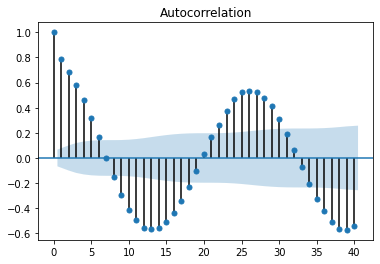

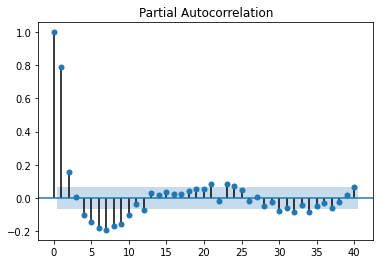

In [425]:
sm.graphics.tsa.plot_acf(df['PJME_MW'].values, lags=40)
plt.show()

sm.graphics.tsa.plot_pacf(df['PJME_MW'].values, lags=40)
plt.show()

Согласно графикам P=(1,7) Q=12

Построим признаки 1е, 4е разности.

In [426]:
first_diff = np.array(df.iloc[1:, 0].values - df.iloc[:-1, 0].values).astype('float32')
df['diff1'] = 0
df['diff1'] = df['diff1'].astype(float)
df['diff1'].values[1:] = first_diff

In [427]:
fourth_diff = np.array(df.iloc[4:, 0].values - df.iloc[:-4, 0].values).astype('float32')
df['diff4'] = 0
df['diff4'] = df['diff4'].astype(float)
df['diff4'].values[4:] = fourth_diff

twelfth_diff = np.array(df.iloc[12:, 0].values - df.iloc[:-12, 0].values).astype('float32')
df['diff12'] = 0
df['diff12'] = df['diff12'].astype(float)
df['diff12'].values[12:] = twelfth_diff

Построим признаки 1е, 4е отношения разностей на элементы

In [428]:
first_diff_d =(first_diff) / df.iloc[1:,0].values
df['diff1_d'] = 0
df['diff1_d'] =  df['diff1_d'].astype('float') 
df['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

In [429]:
fourth_diff_d =(fourth_diff) / df.iloc[4:,0].values
df['diff4_d'] = 0
df['diff4_d'] =  df['diff4_d'].astype('float') 
df['diff4_d'].values[4:] = np.array(fourth_diff_d).astype('float32')

twelfth_diff_d =(twelfth_diff) / df.iloc[12:,0].values
df['diff12_d'] = 0
df['diff12_d'] =  df['diff12_d'].astype('float') 
df['diff12_d'].values[12:] = np.array(twelfth_diff_d).astype('float32')

Построим признаки 1е, 4е логарифмы разностей

In [430]:
first_diff_l =np.log(df.iloc[1:,0].values) 
df['diff1_l'] = 0
df['diff1_l'] =  df['diff1_l'].astype('float') 
df['diff1_l'].values[1:] = first_diff_l

In [431]:
fourth_diff_l =np.log(df.iloc[4:,0].values) 
df['diff4_l'] = 0
df['diff4_l'] =  df['diff4_l'].astype('float') 
df['diff4_l'].values[4:] = fourth_diff_l

twelfth_diff_l =np.log(df.iloc[12:,0].values) 
df['diff12_l'] = 0
df['diff12_l'] =  df['diff12_l'].astype('float') 
df['diff12_l'].values[12:] = twelfth_diff_l

Построим признаки 4х недельные сглаживания

In [432]:
df['d_w4']=df['PJME_MW'].rolling(window=4).mean()
#df['d_w12']=df['PJME_MW'].rolling(window=12).mean()

In [433]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

Построим экспоненциальные сглаживания

In [434]:
df['exp_0_03'] = exponential_smoothing(df['PJME_MW'], 0.03)
df['exp_0_05'] = exponential_smoothing(df['PJME_MW'], 0.05)
df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.08)
df['exp_0_1'] = exponential_smoothing(df['PJME_MW'], 0.1)

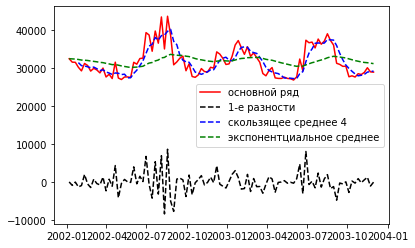

In [435]:
N100=100
plt.plot(df.index[:N100],df['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(df.index[:N100],df['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(df.index[:N100],df['d_w4'][:N100],'--b',label ='скользящее среднее 4')
plt.plot(df.index[:N100],df['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

In [436]:
p = 7
for i in range(p):
    df['t'+str(p-i)]=0
    df['t'+str(p-i)].values[p:] = df['PJME_MW'].values[i:-(p)+i]

In [437]:
for i in range(p):
    df['d'+str(p-i)]=0
    df['d'+str(p-i)].values[p:] = df['diff1'].values[i:-(p)+i]

In [438]:
df.fillna(0, inplace=True)

In [439]:
df.head(15)

,PJME_MW,is_holiday,diff1,diff4,diff1_d,diff4_d,diff1_l,diff4_l,d_w4,exp_0_03,...,t3,t2,t1,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,0.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32392.160839,...,0,0,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,0.000000,-904.773926,0.000000,-0.028734,0.000000,10.357342,0.000000,0.000000,32365.017621,...,0,0,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,0.000000,-34.505951,0.000000,-0.001097,0.000000,10.356246,0.000000,0.000000,32337.653521,...,0,0,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,0.142857,-1311.351196,0.000000,-0.043506,0.000000,10.313659,0.000000,31368.489615,32271.769808,...,0,0,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,0.000000,-945.041687,-3195.672852,-0.032368,-0.109454,10.281804,10.281804,30569.571429,32179.511357,...,0,0,0,0,0,0,0,0,0,0
2002-02-10,31150.517857,0.000000,1954.029785,-336.869049,0.062729,-0.010814,10.346586,10.346586,30485.354167,32148.641552,...,0,0,0,0,0,0,0,0,0,0
2002-02-17,30616.565476,0.000000,-533.952393,-836.315491,-0.017440,-0.027316,10.329296,10.329296,30276.275298,32102.679270,...,0,0,0,0,0,0,0,0,0,0
2002-02-24,29144.130952,0.142857,-1472.434570,-997.398804,-0.050523,-0.034223,10.280009,10.280009,30026.925595,32013.922820,...,29196,31150,30616,0,-904,-34,-1311,-945,1954,-533
2002-03-03,29869.011905,0.000000,724.880981,672.523804,0.024269,0.022516,10.304577,10.304577,30195.056548,31949.575493,...,31150,30616,29144,-904,-34,-1311,-945,1954,-533,-1472


In [440]:
h = 4

In [441]:
scl_target = StandardScaler()
target = df['PJME_MW'].values[p+h:].reshape(-1, 1)
y = scl_target.fit_transform(target)
y.shape

(855, 1)

In [442]:
scl_x=StandardScaler() 

X = df.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(855, 27)

In [443]:
f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.48,  I=0
F-test=0.03,  I=1
F-test=0.09,  I=2
F-test=0.96,  I=3
F-test=0.09,  I=4
F-test=1.00,  I=5
F-test=0.49,  I=6
F-test=0.49,  I=7
F-test=0.14,  I=8
F-test=0.04,  I=9
F-test=0.06,  I=10
F-test=0.05,  I=11
F-test=0.04,  I=12
F-test=0.58,  I=13
F-test=0.38,  I=14
F-test=0.18,  I=15
F-test=0.04,  I=16
F-test=0.00,  I=17
F-test=0.05,  I=18
F-test=0.21,  I=19
F-test=0.02,  I=20
F-test=0.03,  I=21
F-test=0.06,  I=22
F-test=0.10,  I=23
F-test=0.11,  I=24
F-test=0.12,  I=25
F-test=0.11,  I=26


In [444]:
pd.Series(df.columns)

0        PJME_MW
1     is_holiday
2          diff1
3          diff4
4        diff1_d
5        diff4_d
6        diff1_l
7        diff4_l
8           d_w4
9       exp_0_03
10      exp_0_05
11      exp_0_08
12       exp_0_1
13            t7
14            t6
15            t5
16            t4
17            t3
18            t2
19            t1
20            d7
21            d6
22            d5
23            d4
24            d3
25            d2
26            d1
dtype: object

In [445]:
sfk= SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(855, 5)

In [446]:
column_names = df.columns[sfk.get_support()]
column_names

Index(['diff4', 'diff4_d', 'diff1_l', 'diff4_l', 't7'], dtype='object')

In [447]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(855, 3)

In [448]:
column_namesp = df.columns[sfp.get_support()]
column_namesp

Index(['diff4', 'diff4_d', 't7'], dtype='object')

In [449]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(855, 4)

In [450]:
column_namesp = df.columns[sfm.get_support()]
column_namesp

Index(['diff4_d', 'exp_0_03', 't7', 'd4'], dtype='object')

In [451]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 3  5  6  7 13]
Номера признаков лучших признаков по процентной форме:  [ 3  5 13]
Номера признаков для выбора по модели :  [ 5  9 13 23]


In [481]:
list_par = list(list_param_k.copy())
list_par.extend(list(list_param_p))
list_par.extend(list(list_param_m))
list_par = list(set(list_par))
list_par.insert(0, 0)
print(list_par)

[0, 3, 5, 6, 7, 9, 13, 23]


In [482]:
X_new = df.iloc[p:-h,list_par].values
scl_x = StandardScaler()
X_new = scl_x.fit_transform(X_new)
X_new.shape

(858, 8)

In [483]:
df.iloc[p:-h,list_par].columns

Index(['PJME_MW', 'diff4', 'diff4_d', 'diff1_l', 'diff4_l', 'exp_0_03', 't7',
       'd4'],
      dtype='object')

In [484]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

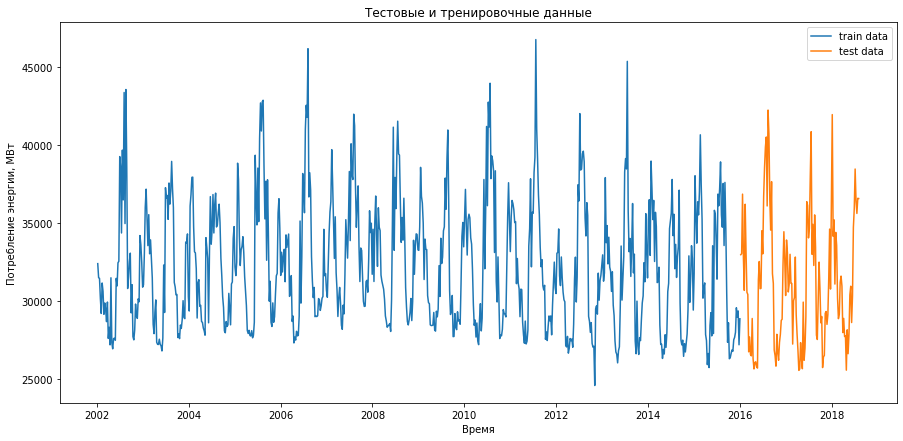

In [485]:
train, test = split_data(df, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [486]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [487]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [488]:
model_g.fit(X_train, y_train )

GradientBoostingRegressor(max_depth=5, random_state=0)

In [489]:
y_test_pred_g = model_g.predict(X_test)

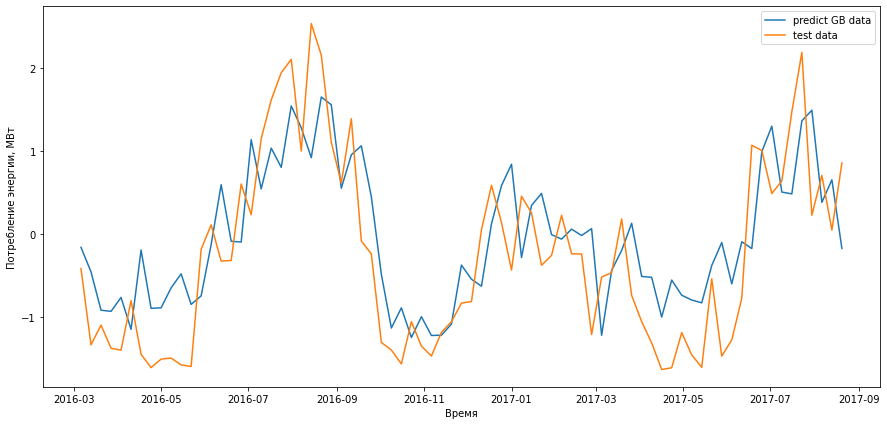

In [490]:
plt.figure( figsize=( 15, 7 ))

G = 50
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:-G],y_test_pred_g[:-G], label='predict GB data' )
plt.plot(test.index[h+p:-G],y_test[:-G], label='test data')

plt.legend()
plt.show()

In [491]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

In [492]:
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.5541556867748156 
ошибка mae  :   0.6082826435692814 
оценка R2 :   0.48161862644985454


In [493]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [494]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.987775240112223 %


### Задание 3
Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [495]:
h = 1

In [496]:
scl_target = StandardScaler()
target = df['PJME_MW'].values[p+h:].reshape(-1, 1)
y = scl_target.fit_transform(target)
y.shape

(858, 1)

In [497]:
X_new = df.iloc[p:-h,list_par].values
scl_x = StandardScaler()
X_new = scl_x.fit_transform(X_new)
X_new.shape

(858, 8)

In [ ]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [ ]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [ ]:
model_g.fit(X_train, y_train )

In [ ]:
y_test_pred_g = model_g.predict(X_test)

In [ ]:
plt.figure( figsize=( 15, 7 ))

G = 50
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:-G],y_test_pred_g[:-G], label='predict GB data' )
plt.plot(test.index[h+p:-G],y_test[:-G], label='test data')

plt.legend()
plt.show()

In [ ]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

In [ ]:
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

In [ ]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

### Задание 4
Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#'diff4', 'diff4_d', 'diff1_l', 'diff4_l', 'exp_0_03', 't7', 'd4']

X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 100
for i in range(N10):
    
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape(1,8))
    
    # PJME_MW
    X_test_100[i+1, 0] = y_test_100[i]
    
    X_test_100[:i+1+1,0] = scl_target.inverse_transform(X_test_100[:i+1+1,0])
    
    #diff4
    X_test_100[i+1, 1] = X_test_100[i+1, 0] - X_test_100[i+1-4, 0] if i >= 3 else 0
    
    #diff4_d
    X_test_100[i+1, 2] = X_test_100[i+1, 1] / X_test_100[i+1, 0]
    
    #diff1_l
    X_test_100[i+1, 3] = np.log(X_test_100[i+1, 0] - X_test_100[i+1-1, 0])
    
    #diff4_l
    X_test_100[i+1, 4] = np.log(X_test_100[i+1, 0] - X_test_100[i+1-4, 0]) if i >= 3 else 0
    
    #exp_0_03
    X_test_100[i+1, 5] = X_test_100[i+1,0]*(1-0.03)+ 0.03 * X_test_100[i,5]

    #t7
    X_test_100[i+1, 6] = X_test_100[i+1 - 7, 0] if i >= 6 else 0
    
    #d4
    if i >= 3:
        diff1 = X_test_100[1:i+1+1, 0] - X_test_100[:i+1, 0]
        X_test_100[i+1, 7] = diff1[-4]

    X_test_100[:i+1+1] = np.nan_to_num(X_test_100[:i+1+1])
    
    X_test_100[:i+1+1] = scl_x.transform(X_test_100[:i+1+1])
            
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()

### Задание 5
Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

In [ ]:
for j in [0,10,20,30,40, 50, 60, 70, 80, 90]:
    er_100j = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[j:j+10]),y_pred = scl_target.inverse_transform( y_test_100[p+1+j:j+10+p+1]))

    print('ошибка рекурсивной модели на отрезке',j,':',j+10,'  MAPE :  ', er_100j,'%')

In [498]:
for j in [0,10,20,30,40, 50, 60, 70, 80, 90]:
    er_100j = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[j:j+10]),y_pred = scl_target.inverse_transform( y_test_100[p+1+j:j+10+p+1]))

    print('ошибка рекурсивной модели на отрезке',j,':',j+10,'  MAPE :  ', er_100j,'%')

In [499]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [500]:
model_g.fit(X_train, y_train )

GradientBoostingRegressor(max_depth=5, random_state=0)

In [501]:
y_test_pred_g = model_g.predict(X_test)

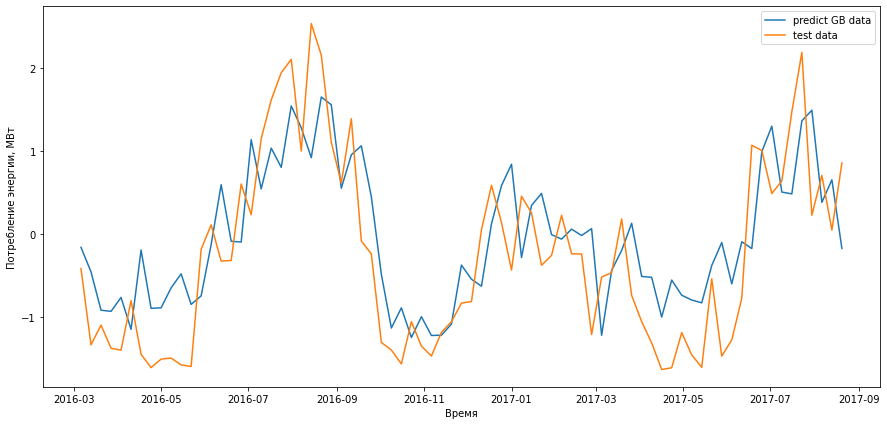

In [502]:
plt.figure( figsize=( 15, 7 ))

G = 50
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:-G],y_test_pred_g[:-G], label='predict GB data' )
plt.plot(test.index[h+p:-G],y_test[:-G], label='test data')

plt.legend()
plt.show()

In [503]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

In [504]:
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.5541556867748156 
ошибка mae  :   0.6082826435692814 
оценка R2 :   0.48161862644985454


In [505]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.987775240112223 %


### Задание 4
Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [352]:
import warnings
warnings.filterwarnings("ignore")

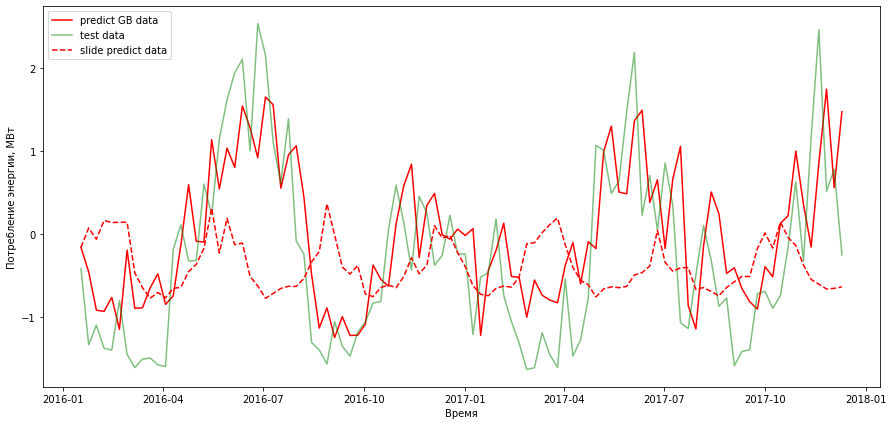

In [510]:
#'diff4', 'diff4_d', 'diff1_l', 'diff4_l', 'exp_0_03', 't7', 'd4']

X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 100
for i in range(N10):
    
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape(1,8))
    
    # PJME_MW
    X_test_100[i+1, 0] = y_test_100[i]
    
    X_test_100[:i+1+1,0] = scl_target.inverse_transform(X_test_100[:i+1+1,0])
    
    #diff4
    X_test_100[i+1, 1] = X_test_100[i+1, 0] - X_test_100[i+1-4, 0] if i >= 3 else 0
    
    #diff4_d
    X_test_100[i+1, 2] = X_test_100[i+1, 1] / X_test_100[i+1, 0]
    
    #diff1_l
    X_test_100[i+1, 3] = np.log(X_test_100[i+1, 0] - X_test_100[i+1-1, 0])
    
    #diff4_l
    X_test_100[i+1, 4] = np.log(X_test_100[i+1, 0] - X_test_100[i+1-4, 0]) if i >= 3 else 0
    
    #exp_0_03
    X_test_100[i+1, 5] = X_test_100[i+1,0]*(1-0.03)+ 0.03 * X_test_100[i,5]

    #t7
    X_test_100[i+1, 6] = X_test_100[i+1 - 7, 0] if i >= 6 else 0
    
    #d4
    if i >= 3:
        diff1 = X_test_100[1:i+1+1, 0] - X_test_100[:i+1, 0]
        X_test_100[i+1, 7] = diff1[-4]

    X_test_100[:i+1+1] = np.nan_to_num(X_test_100[:i+1+1])
    
    X_test_100[:i+1+1] = scl_x.transform(X_test_100[:i+1+1])
            
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()

### Задание 5
Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

In [513]:
for j in [0,10,20,30,40, 50, 60, 70, 80, 90]:
    er_100j = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[j:j+10]),y_pred = scl_target.inverse_transform( y_test_100[p+1+j:j+10+p+1]))

    print('ошибка рекурсивной модели на отрезке',j,':',j+10,'  MAPE :  ', er_100j,'%')

ошибка рекурсивной модели на отрезке 0 : 10   MAPE :   12.266615702927734 %
ошибка рекурсивной модели на отрезке 10 : 20   MAPE :   12.906188024766758 %
ошибка рекурсивной модели на отрезке 20 : 30   MAPE :   16.429292856112326 %
ошибка рекурсивной модели на отрезке 30 : 40   MAPE :   11.473153406420717 %
ошибка рекурсивной модели на отрезке 40 : 50   MAPE :   6.788355295160545 %
ошибка рекурсивной модели на отрезке 50 : 60   MAPE :   9.121537784915418 %
ошибка рекурсивной модели на отрезке 60 : 70   MAPE :   10.606218940233603 %
ошибка рекурсивной модели на отрезке 70 : 80   MAPE :   14.134574682201912 %
ошибка рекурсивной модели на отрезке 80 : 90   MAPE :   8.464863888992022 %
ошибка рекурсивной модели на отрезке 90 : 100   MAPE :   10.370513166325772 %
